In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -qq "/content/gdrive/MyDrive/godaddy-microbusiness-density-forecasting.zip"

In [ ]:
#gc 모듈은 Python에서 메모리 관리를 돕는 기능을 제공합니다
import gc

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm.notebook import tqdm

In [ ]:
def smape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * np.mean(smap)

In [ ]:
def vsmape(y_true, y_pred):
    smap = np.zeros(len(y_true))
    
    num = np.abs(y_true - y_pred)
    dem = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    pos_ind = (y_true!=0)|(y_pred!=0)
    smap[pos_ind] = num[pos_ind] / dem[pos_ind]
    
    return 100 * smap

In [ ]:
census = pd.read_csv('/content/census_starter.csv')
print(census.columns)
census.head()

Index(['pct_bb_2017', 'pct_bb_2018', 'pct_bb_2019', 'pct_bb_2020',
       'pct_bb_2021', 'cfips', 'pct_college_2017', 'pct_college_2018',
       'pct_college_2019', 'pct_college_2020', 'pct_college_2021',
       'pct_foreign_born_2017', 'pct_foreign_born_2018',
       'pct_foreign_born_2019', 'pct_foreign_born_2020',
       'pct_foreign_born_2021', 'pct_it_workers_2017', 'pct_it_workers_2018',
       'pct_it_workers_2019', 'pct_it_workers_2020', 'pct_it_workers_2021',
       'median_hh_inc_2017', 'median_hh_inc_2018', 'median_hh_inc_2019',
       'median_hh_inc_2020', 'median_hh_inc_2021'],
      dtype='object')


,pct_bb_2017,pct_bb_2018,pct_bb_2019,pct_bb_2020,pct_bb_2021,cfips,pct_college_2017,pct_college_2018,pct_college_2019,pct_college_2020,...,pct_it_workers_2017,pct_it_workers_2018,pct_it_workers_2019,pct_it_workers_2020,pct_it_workers_2021,median_hh_inc_2017,median_hh_inc_2018,median_hh_inc_2019,median_hh_inc_2020,median_hh_inc_2021
0,76.6,78.9,80.6,82.7,85.5,1001,14.5,15.9,16.1,16.7,...,1.3,1.1,0.7,0.6,1.1,55317,58786.0,58731,57982.0,62660.0
1,74.5,78.1,81.8,85.1,87.9,1003,20.4,20.7,21.0,20.2,...,1.4,1.3,1.4,1.0,1.3,52562,55962.0,58320,61756.0,64346.0
2,57.2,60.4,60.5,64.6,64.6,1005,7.6,7.8,7.6,7.3,...,0.5,0.3,0.8,1.1,0.8,33368,34186.0,32525,34990.0,36422.0
3,62.0,66.1,69.2,76.1,74.6,1007,8.1,7.6,6.5,7.4,...,1.2,1.4,1.6,1.7,2.1,43404,45340.0,47542,51721.0,54277.0
4,65.8,68.5,73.0,79.6,81.0,1009,8.7,8.1,8.6,8.9,...,1.3,1.4,0.9,1.1,0.9,47412,48695.0,49358,48922.0,52830.0


In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
sub = pd.read_csv('/content/sample_submission.csv')
print(train.shape, test.shape, sub.shape)

(122265, 7) (25080, 3) (25080, 2)


In [ ]:
train

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243
...,...,...,...,...,...,...,...
122260,56045_2022-06-01,56045,Weston County,Wyoming,2022-06-01,1.803249,101
122261,56045_2022-07-01,56045,Weston County,Wyoming,2022-07-01,1.803249,101
122262,56045_2022-08-01,56045,Weston County,Wyoming,2022-08-01,1.785395,100
122263,56045_2022-09-01,56045,Weston County,Wyoming,2022-09-01,1.785395,100


In [ ]:
test

,row_id,cfips,first_day_of_month
0,1001_2022-11-01,1001,2022-11-01
1,1003_2022-11-01,1003,2022-11-01
2,1005_2022-11-01,1005,2022-11-01
3,1007_2022-11-01,1007,2022-11-01
4,1009_2022-11-01,1009,2022-11-01
...,...,...,...
25075,56037_2023-06-01,56037,2023-06-01
25076,56039_2023-06-01,56039,2023-06-01
25077,56041_2023-06-01,56041,2023-06-01
25078,56043_2023-06-01,56043,2023-06-01


In [ ]:
sub

,row_id,microbusiness_density
0,1001_2022-11-01,3.817671
1,1003_2022-11-01,3.817671
2,1005_2022-11-01,3.817671
3,1007_2022-11-01,3.817671
4,1009_2022-11-01,3.817671
...,...,...
25075,56037_2023-06-01,3.817671
25076,56039_2023-06-01,3.817671
25077,56041_2023-06-01,3.817671
25078,56043_2023-06-01,3.817671


In [ ]:
train['istest'] = 0
test['istest'] = 1

In [ ]:
#reset_index(drop=True)---> 데이터프레임의 인덱스를 재설정하는 함수
#sort_values(['cfips','row_id'])는 일단 cfips를 기준으로 정렬하고, 만일 cfips가 동일하다면
#row_id를 기준으로 정렬렬
raw = pd.concat((train,test)).sort_values(['cfips','row_id']).reset_index(drop=True)

In [ ]:
raw

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0
...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,NaN,NaN,2023-02-01,NaN,NaN,1
147341,56045_2023-03-01,56045,NaN,NaN,2023-03-01,NaN,NaN,1
147342,56045_2023-04-01,56045,NaN,NaN,2023-04-01,NaN,NaN,1
147343,56045_2023-05-01,56045,NaN,NaN,2023-05-01,NaN,NaN,1


In [ ]:
#pd.to_datetime()은 문자열로 표현된 날짜나 시간 데이터를
#파이썬 datetime 객체로 변환해주는 함수입니다
raw['first_day_of_month'] = pd.to_datetime(raw["first_day_of_month"])

In [ ]:
#dataframe.groupby('그룹화 기준 열')['계산 대상 열'].함수()
#이 코드를 좀 더 쉽게 설명하자면 cfips가 1001이면서 county가 Autauga County이면 
#cfips가 1001이면서 county가 결측치면 모두 Autauga County로 대체한다는 의미다.
raw['county'] = raw.groupby('cfips')['county'].ffill()

In [ ]:
raw

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0
...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,Weston County,NaN,2023-02-01,NaN,NaN,1
147341,56045_2023-03-01,56045,Weston County,NaN,2023-03-01,NaN,NaN,1
147342,56045_2023-04-01,56045,Weston County,NaN,2023-04-01,NaN,NaN,1
147343,56045_2023-05-01,56045,Weston County,NaN,2023-05-01,NaN,NaN,1


In [ ]:
raw['state'] = raw.groupby('cfips')['state'].ffill()

In [ ]:
# dt.year을 사용하면 연도에 해당하는 부분만 추출할 수 있습니다.
raw["year"] = raw["first_day_of_month"].dt.year
# dt.month 사용하면 연도에 해당하는 부분만 추출할 수 있습니다.
raw["month"] = raw["first_day_of_month"].dt.month

In [ ]:
raw

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12
...,...,...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,NaN,NaN,1,2023,2
147341,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,NaN,NaN,1,2023,3
147342,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,NaN,NaN,1,2023,4
147343,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,NaN,NaN,1,2023,5


In [ ]:
#cumcount() 함수는 그룹 내에서 현재 행을 포함하여 그 이전까지의 행의 수를 누적하여 
#계산하는 함수이기 때문에, 결과값으로 현재 행의 순번을 반환합니다
#dcount는 시간별로 순번을 지정한 것
raw["dcount"] = raw.groupby(['cfips'])['row_id'].cumcount()

In [ ]:
raw.sort_values('dcount')

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_1,state_i,mbd_lag_1,dif
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0,3.007682,0.0
84224,35001_2019-08-01,35001,Bernalillo County,New Mexico,2019-08-01,6.197286,32345.0,0,2019,8,0,1792,31,6.197286,0.0
63121,27063_2019-08-01,27063,Jackson County,Minnesota,2019-08-01,1.856798,146.0,0,2019,8,0,1343,23,1.856798,0.0
35297,18113_2019-08-01,18113,Noble County,Indiana,2019-08-01,2.080208,735.0,0,2019,8,0,751,14,2.080208,0.0
112048,46053_2019-08-01,46053,Gregory County,South Dakota,2019-08-01,2.797637,90.0,0,2019,8,0,2384,41,2.797637,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104621,41041_2023-06-01,41041,Lincoln County,Oregon,2023-06-01,NaN,NaN,1,2023,6,46,2225,37,3.946464,0.0
58984,26051_2023-06-01,26051,Gladwin County,Michigan,2023-06-01,NaN,NaN,1,2023,6,46,1254,22,1.952888,0.0
24768,13287_2023-06-01,13287,Turner County,Georgia,2023-06-01,NaN,NaN,1,2023,6,46,526,10,2.408564,0.0
33134,18019_2023-06-01,18019,Clark County,Indiana,2023-06-01,NaN,NaN,1,2023,6,46,704,14,2.017462,0.0


In [ ]:
raw

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_1,state_i,mbd_lag_1,dif
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0,3.007682,0.000000
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,3.007682,0.040833
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,2.884870,0.059265
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,3,0,0,3.055843,0.020489
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,4,0,0,2.993233,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,NaN,NaN,1,2023,2,42,3134,50,NaN,0.000000
147341,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,NaN,NaN,1,2023,3,43,3134,50,NaN,0.000000
147342,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,NaN,NaN,1,2023,4,44,3134,50,NaN,0.000000
147343,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,NaN,NaN,1,2023,5,45,3134,50,NaN,0.000000


In [ ]:
#(array([0, 1, 2, 0, 1, 3]), array(['a', 'b', 'c', 'd'], dtype=object))
#반환을 이런 튜플로 하기 때문에, 정수부분만 가지고 오기 위해서 [0]을 추가함.
#factorize 판다스에서 인코딩하는 것
raw['county_1'] = (raw['county']+raw['state']).factorize()[0]

In [ ]:
raw['state_i'] = raw['state'].factorize()[0]

In [ ]:
raw

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_1,state_i
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,3,0,0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,NaN,NaN,1,2023,2,42,3134,50
147341,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,NaN,NaN,1,2023,3,43,3134,50
147342,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,NaN,NaN,1,2023,4,44,3134,50
147343,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,NaN,NaN,1,2023,5,45,3134,50


이상치가 존재한다.

In [ ]:
raw

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_1,state_i
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,3,0,0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,NaN,NaN,1,2023,2,42,3134,50
147341,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,NaN,NaN,1,2023,3,43,3134,50
147342,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,NaN,NaN,1,2023,4,44,3134,50
147343,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,NaN,NaN,1,2023,5,45,3134,50


In [ ]:
#shift() 함수는 데이터프레임의 행을 위나 아래로 이동시키는 함수입니다.
#이 함수는 데이터프레임을 변경하지 않고 이동한 결과를 반환합니다.
#shift(n)은 n만큼 이동하며, 음수 값을 입력하면 그만큼 아래로 이동합니다
#즉 지금 lag가 1이니까 1칸씩 옮긴거
#
lag = 1
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()

In [ ]:
raw

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_1,state_i,mbd_lag_1
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0,3.007682
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,3.007682
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,2.884870
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,3,0,0,3.055843
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,4,0,0,2.993233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,NaN,NaN,1,2023,2,42,3134,50,NaN
147341,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,NaN,NaN,1,2023,3,43,3134,50,NaN
147342,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,NaN,NaN,1,2023,4,44,3134,50,NaN
147343,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,NaN,NaN,1,2023,5,45,3134,50,NaN


In [ ]:
# 즉, 이전 기간 대비 상대적인 증감률을 계산
#clip(0, None)는 Series나 DataFrame 안의 모든 값들을 0 이하의 값은 0으로, None(즉, 무한대) 이상의 값은 그대로 유지하도록 변경하는 메소드, -0.5는 0으로, 0.5는 0.5로 리턴
#-1를 함으로써 (현재 값/이전 값)-1을 해서 이전값 대비 성장률을 알 수 있다. 양수인지 음수인지에 따라 성장률이 달라짐
raw['dif'] = (raw['microbusiness_density']/raw[f'mbd_lag_{lag}']).fillna(1).clip(0,None) -1

In [ ]:
#해당 코드는 raw[f'mbd_lag_{lag}'] 열의 값이 0인 경우, raw['dif'] 열의 값을 0으로 바꾸는 코드
raw.loc[(raw[f'mbd_lag_{lag}']==0), 'dif'] = 0

In [ ]:
raw

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_1,state_i,mbd_lag_1,dif
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0,3.007682,0.000000
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,3.007682,-0.040833
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,2.884870,0.059265
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,3,0,0,3.055843,-0.020489
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,4,0,0,2.993233,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,NaN,NaN,1,2023,2,42,3134,50,NaN,0.000000
147341,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,NaN,NaN,1,2023,3,43,3134,50,NaN,0.000000
147342,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,NaN,NaN,1,2023,4,44,3134,50,NaN,0.000000
147343,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,NaN,NaN,1,2023,5,45,3134,50,NaN,0.000000


In [ ]:
raw.loc[(raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}']==0), 'dif'] = 1

In [ ]:
raw

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_1,state_i,mbd_lag_1,dif
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0,3.007682,0.000000
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,3.007682,-0.040833
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,2.884870,0.059265
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,3,0,0,3.055843,-0.020489
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,4,0,0,2.993233,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,NaN,NaN,1,2023,2,42,3134,50,NaN,0.000000
147341,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,NaN,NaN,1,2023,3,43,3134,50,NaN,0.000000
147342,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,NaN,NaN,1,2023,4,44,3134,50,NaN,0.000000
147343,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,NaN,NaN,1,2023,5,45,3134,50,NaN,0.000000


In [ ]:
raw['dif'] = raw['dif'].abs()

In [ ]:
raw

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_1,state_i,mbd_lag_1,dif
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0,3.007682,0.000000
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,3.007682,0.040833
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,2.884870,0.059265
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,3,0,0,3.055843,0.020489
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,4,0,0,2.993233,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,NaN,NaN,1,2023,2,42,3134,50,NaN,0.000000
147341,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,NaN,NaN,1,2023,3,43,3134,50,NaN,0.000000
147342,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,NaN,NaN,1,2023,4,44,3134,50,NaN,0.000000
147343,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,NaN,NaN,1,2023,5,45,3134,50,NaN,0.000000


<Axes: xlabel='dcount'>

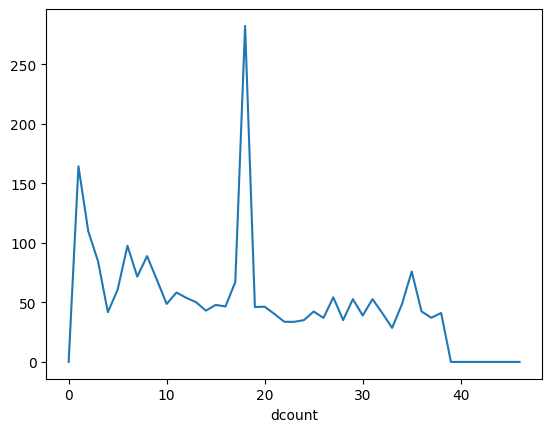

In [ ]:
##dcount는 시간별로 순번을 지정한 것, 즉 dcount가 0이면 2019-08-01이고, dcount가 44면 2023-04-01이라는 말임
#그래프 해석을 해보면 약 18에서 과도한 dif가 보인다.
raw.groupby('dcount')['dif'].sum().plot()

In [ ]:
raw.cfips.unique()

array([ 1001,  1003,  1005, ..., 56041, 56043, 56045])

In [ ]:
raw

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_1,state_i,mbd_lag_1,dif
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249.0,0,2019,8,0,0,0,3.007682,0.000000
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,3.007682,0.040833
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,2.884870,0.059265
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,3,0,0,3.055843,0.020489
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,4,0,0,2.993233,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,NaN,NaN,1,2023,2,42,3134,50,NaN,0.000000
147341,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,NaN,NaN,1,2023,3,43,3134,50,NaN,0.000000
147342,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,NaN,NaN,1,2023,4,44,3134,50,NaN,0.000000
147343,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,NaN,NaN,1,2023,5,45,3134,50,NaN,0.000000


In [ ]:
outliers = []
cnt = 0
for o in tqdm(raw.cfips.unique()):
  #해당 
  indices = (raw['cfips']==o)
  tmp = raw.loc[indices].copy().reset_index(drop=True)
  var = tmp.microbusiness_density.values.copy()
  #37부터 3까지 1씩 감소
  for i in range(37, 2, -1):
        thr = 0.20*np.mean(var[:i])
        difa = abs(var[i]-var[i-1])
        if (difa>=thr):
            var[:i] *= (var[i]/var[i-1])
            outliers.append(o)
            cnt+=1
  var[0] = var[1]*0.99
  raw.loc[indices, 'microbusiness_density'] = var
    
outliers = np.unique(outliers)
len(outliers), cnt

  0%|          | 0/3135 [00:00<?, ?it/s]

<ipython-input-83-09047e70f681>:13: RuntimeWarning: invalid value encountered in double_scalars
  var[:i] *= (var[i]/var[i-1])
<ipython-input-83-09047e70f681>:13: RuntimeWarning: divide by zero encountered in double_scalars
  var[:i] *= (var[i]/var[i-1])
<ipython-input-83-09047e70f681>:13: RuntimeWarning: invalid value encountered in multiply
  var[:i] *= (var[i]/var[i-1])
<ipython-input-83-09047e70f681>:11: RuntimeWarning: invalid value encountered in double_scalars
  difa = abs(var[i]-var[i-1])


(481, 732)

In [ ]:
len(var)

47

In [ ]:
tmp

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_1,state_i,mbd_lag_1,dif
0,56045_2019-08-01,56045,Weston County,Wyoming,2019-08-01,1.548594,87.0,0,2019,8,0,3134,50,1.548594,0.000000
1,56045_2019-09-01,56045,Weston County,Wyoming,2019-09-01,1.530794,86.0,0,2019,9,1,3134,50,1.548594,0.011494
2,56045_2019-10-01,56045,Weston County,Wyoming,2019-10-01,1.530794,86.0,0,2019,10,2,3134,50,1.530794,0.000000
3,56045_2019-11-01,56045,Weston County,Wyoming,2019-11-01,1.601994,90.0,0,2019,11,3,3134,50,1.530794,0.046512
4,56045_2019-12-01,56045,Weston County,Wyoming,2019-12-01,1.584194,89.0,0,2019,12,4,3134,50,1.601994,0.011111
5,56045_2020-01-01,56045,Weston County,Wyoming,2020-01-01,1.590706,89.0,0,2020,1,5,3134,50,1.584194,0.004111
6,56045_2020-02-01,56045,Weston County,Wyoming,2020-02-01,1.519214,85.0,0,2020,2,6,3134,50,1.590706,0.044944
7,56045_2020-03-01,56045,Weston County,Wyoming,2020-03-01,1.537087,86.0,0,2020,3,7,3134,50,1.519214,0.011765
8,56045_2020-04-01,56045,Weston County,Wyoming,2020-04-01,1.554960,87.0,0,2020,4,8,3134,50,1.537087,0.011628
9,56045_2020-05-01,56045,Weston County,Wyoming,2020-05-01,1.608579,90.0,0,2020,5,9,3134,50,1.554960,0.034483


In [ ]:
indices

0         False
1         False
2         False
3         False
4         False
          ...  
147340     True
147341     True
147342     True
147343     True
147344     True
Name: cfips, Length: 147345, dtype: bool

<Axes: xlabel='dcount'>

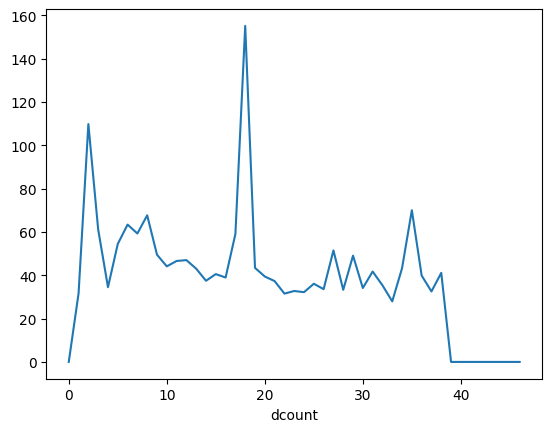

In [ ]:
lag = 1
raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')['microbusiness_density'].shift(lag).bfill()
raw['dif'] = (raw['microbusiness_density'] / raw[f'mbd_lag_{lag}']).fillna(1).clip(0, None) - 1
raw.loc[(raw[f'mbd_lag_{lag}']==0), 'dif'] = 0
raw.loc[(raw[f'microbusiness_density']>0) & (raw[f'mbd_lag_{lag}']==0), 'dif'] = 1
raw['dif'] = raw['dif'].abs()
raw.groupby('dcount')['dif'].sum().plot()

<Axes: xlabel='dcount'>

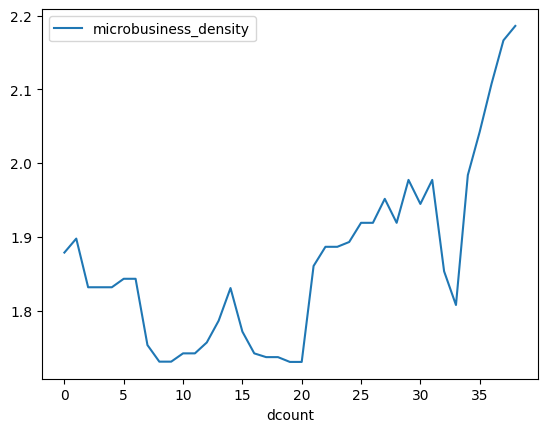

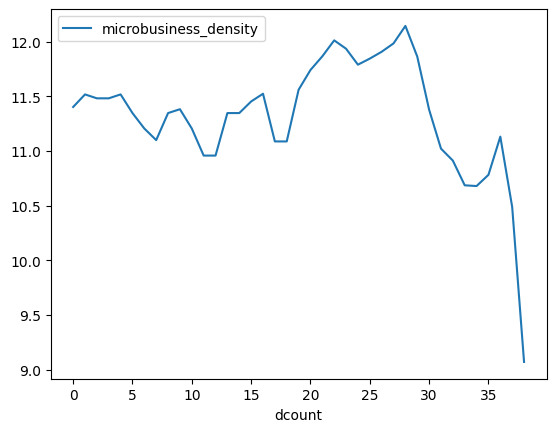

In [ ]:
raw.loc[raw.cfips == 1013].plot(x='dcount', y='microbusiness_density')
raw.loc[raw.cfips == 21215].plot(x='dcount', y='microbusiness_density')

SMAPE is a relative metric so target must be converted

SMAPE는 Symmetric Mean Absolute Percentage Error의 약자로, 예측값과 실제 값 사이의 오차를 비율로 표현하는 측정 기준입니다. 그래서 대상(target)을 변환시켜야 합니다

SMAPE를 계산하기 위해서는 예측값과 실제값의 차이를 비교해야 합니다. 그러나 SMAPE는 상대적인 오차를 계산하는 지표이므로 예측값과 실제값의 차이를 절댓값으로 나누어야 합니다. 이 때, 참값과 예측값 중 작은 값으로 나누어야 하므로 이를 보장하기 위해 참값과 예측값에 0.1을 더해줍니다. 그리고 SMAPE를 계산하기 위해서는 실제값과 예측값의 차이를 절댓값으로 나눈 후, 2를 곱하고 100을 곱한 다음에 실제값과 예측값의 합으로 나눠주어야 합니다. 이렇게 변환된 값으로 SMAPE를 계산하면 됩니다.

In [ ]:
raw['target'] = raw.groupby('cfips')['microbusiness_density'].shift(-1)

In [ ]:
raw['target'] = raw['target']/raw['microbusiness_density'] - 1

In [ ]:
raw.loc[raw['cfips']==28055, 'target'] = 0.0
raw.loc[raw['cfips']==48269, 'target'] = 0.0

<Axes: >

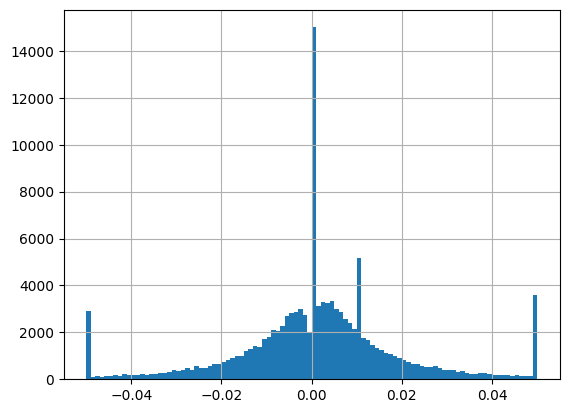

In [ ]:
#-0.05부터 0.05까지의 범위를 벗어나는 값들을 
#모두 해당 범위의 최솟값과 최댓값으로 clip하는 작업을 수행합니다.
raw['target'].clip(-0.05, 0.05).hist(bins=100)

In [ ]:
#transform()은 그룹화된 데이터에 대해 원하는 변환 함수를 적용하여, 그 결과를 전체 데이터프레임에 반영하는 함수
#last() 함수는 groupby된 그룹 내에서 마지막으로 등장하는 값을 반환, 즉 cfips에서 마지막 1001의 active값을 집어 넣는것
raw['lastactive'] = raw.groupby('cfips')['active'].transform('last')

In [ ]:
raw

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_1,state_i,mbd_lag_1,dif,target,lastactive
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,2.856021,1249.0,0,2019,8,0,0,0,2.856021,0.000000,0.010101,1472.0
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,2.856021,0.010101,0.059265,1472.0
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,2.884870,0.059265,-0.020489,1472.0
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,3,0,0,3.055843,0.020489,0.000000,1472.0
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,4,0,0,2.993233,0.000000,-0.008066,1472.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,NaN,NaN,1,2023,2,42,3134,50,NaN,0.000000,NaN,100.0
147341,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,NaN,NaN,1,2023,3,43,3134,50,NaN,0.000000,NaN,100.0
147342,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,NaN,NaN,1,2023,4,44,3134,50,NaN,0.000000,NaN,100.0
147343,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,NaN,NaN,1,2023,5,45,3134,50,NaN,0.000000,NaN,100.0


In [ ]:
dt = raw.loc[raw.dcount==28].groupby('cfips')['microbusiness_density'].agg('last')

In [ ]:
raw['lasttarget'] = raw['cfips'].map(dt)

In [ ]:
raw

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active,istest,year,month,dcount,county_1,state_i,mbd_lag_1,dif,target,lastactive,lasttarget
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,2.856021,1249.0,0,2019,8,0,0,0,2.856021,0.000000,0.010101,1472.0,3.286307
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198.0,0,2019,9,1,0,0,2.856021,0.010101,0.059265,1472.0,3.286307
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269.0,0,2019,10,2,0,0,2.884870,0.059265,-0.020489,1472.0,3.286307
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243.0,0,2019,11,3,0,0,3.055843,0.020489,0.000000,1472.0,3.286307
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243.0,0,2019,12,4,0,0,2.993233,0.000000,-0.008066,1472.0,3.286307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147340,56045_2023-02-01,56045,Weston County,Wyoming,2023-02-01,NaN,NaN,1,2023,2,42,3134,50,NaN,0.000000,NaN,100.0,1.796300
147341,56045_2023-03-01,56045,Weston County,Wyoming,2023-03-01,NaN,NaN,1,2023,3,43,3134,50,NaN,0.000000,NaN,100.0,1.796300
147342,56045_2023-04-01,56045,Weston County,Wyoming,2023-04-01,NaN,NaN,1,2023,4,44,3134,50,NaN,0.000000,NaN,100.0,1.796300
147343,56045_2023-05-01,56045,Weston County,Wyoming,2023-05-01,NaN,NaN,1,2023,5,45,3134,50,NaN,0.000000,NaN,100.0,1.796300


<Axes: >

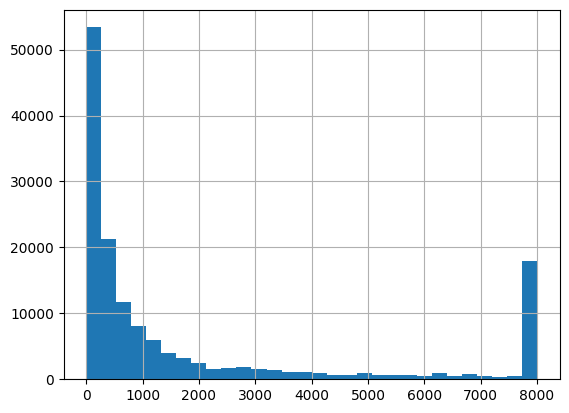

In [ ]:
raw['lastactive'].clip(0, 8000).hist(bins=30)

In [ ]:
def build_features(raw, target='microbusiness_density', target_act='active_tmp', lags = 6):
    feats = []
    for lag in range(1, lags):
        raw[f'mbd_lag_{lag}'] = raw.groupby('cfips')[target].shift(lag)
        raw[f'act_lag_{lag}'] = raw.groupby('cfips')[target_act].diff(lag)
        feats.append(f'mbd_lag_{lag}')
        feats.append(f'act_lag_{lag}')
        
    lag = 1
    for window in [2, 4, 6]:
        raw[f'mbd_rollmea{window}_{lag}'] = raw.groupby('cfips')[f'mbd_lag_{lag}'].transform(lambda s: s.rolling(window, min_periods=1).sum())        
        #raw[f'mbd_rollmea{window}_{lag}'] = raw[f'mbd_lag_{lag}'] - raw[f'mbd_rollmea{window}_{lag}']
        feats.append(f'mbd_rollmea{window}_{lag}')
        
    return raw, feats

In [ ]:
raw, feats = build_features(raw, 'target', 'active', lags = 4)
features = ['state_i']
features += feats
print(features)
raw.loc[raw.dcount==38, features].head(10)

['state_i', 'mbd_lag_1', 'act_lag_1', 'mbd_lag_2', 'act_lag_2', 'mbd_lag_3', 'act_lag_3', 'mbd_rollmea2_1', 'mbd_rollmea4_1', 'mbd_rollmea6_1']


,state_i,mbd_lag_1,act_lag_1,mbd_lag_2,act_lag_2,mbd_lag_3,act_lag_3,mbd_rollmea2_1,mbd_rollmea4_1,mbd_rollmea6_1
38,0,0.006152,9.0,0.005498,17.0,-0.004107,11.0,0.011650,0.034969,0.027467
85,0,0.002170,31.0,-0.017601,-225.0,-0.009601,-366.0,-0.015431,-0.017278,0.049618
132,0,0.020921,5.0,0.008439,7.0,-0.016597,3.0,0.029359,0.033948,0.033966
179,0,-0.021367,-5.0,0.017391,-1.0,-0.025424,-7.0,-0.003976,0.010248,0.028286
226,0,-0.010949,-9.0,0.008589,-2.0,0.002460,0.0,-0.002360,0.033137,0.038372
273,0,0.012987,1.0,0.013158,2.0,0.013333,3.0,0.026145,0.052992,0.080770
320,0,0.009036,3.0,0.027864,12.0,0.031949,22.0,0.036900,0.098454,0.171279
367,0,-0.003180,-8.0,0.007609,11.0,0.002006,16.0,0.004429,0.027747,0.034010
414,0,-0.040201,-16.0,-0.012407,-21.0,-0.017073,-28.0,-0.052608,-0.015697,-0.023285
461,0,-0.012605,-3.0,0.000000,-3.0,-0.008333,-5.0,-0.012605,0.000338,-0.098884
